## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [1]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = 'vS1U6YCHrHykdBrZhxseiA',
    client_secret = 'AL5gAJdYN86p9G73xG9zs_TAXedcUQ',
    user_agent = 'praw'
)
# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    # 'limit' parameter can be increased 
    # in order to expand more comments
    submission.comments.replace_more(limit=64)
    print(len(commentsList))
    i = 0
    for c in commentsList:
        if isinstance(c, praw.models.MoreComments):
            continue
        commentText = c.body
        if commentText in {'[deleted]', '[removed]'}:
            continue
        pandas_list.append([i, commentText])
        i+=1
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

Install wordcloud.

`pip install wordcloud`

1. Import pandas, numpy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [3]:
corpus = getComments('1detli')

902


In [4]:
print(corpus.shape)
corpus.head()

(453, 2)


,id,description
0,0,My father passed away last year. One item he ...
1,1,My mom told me this story the other day and it...
2,2,"When I was 15, my mother and I were standing i..."
3,3,Scariest moment of my life happened while my f...
4,4,I saw a 'shadow person' once.\n\nI didn't know...


In [5]:
print('First spooky story : ',corpus.loc[0,'description'])

First spooky story :  My father passed away last year.  One item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather.  For years he had this shotgun stashed in the attic.  After he passed, I had gone in the attic to look for it, only to find that it wasn't there.

A few months later, I had a dream in which I was talking to him and I asked him where he had put the shotgun.  He told me it was in the closet of a spare bedroom.  I called my mother and had her check, and sure enough that's where it was.

Now it's completely possible that my father had told me that when he was alive, and the dream was little more than a memory, but I certainly don't recall that being the case.


### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [6]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  My father passed away last year.  One item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather.  For years he had this shotgun stashed in the attic.  After he passed, I had gone in the attic to look for it, only to find that it wasn't there.

A few months later, I had a dream in which I was talking to him and I asked him where he had put the shotgun.  He told me it was in the closet of a spare bedroom.  I called my mother and had her check, and sure enough that's where it was.

Now it's completely possible that my father had told me that when he was alive, and the dream was little more than a memory, but I certainly don't recall that being the case.


4. Tranform every character into lowercase.

In [7]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('First story lower-cased : ',corpus.loc[0,'clean_description'])

First story lower-cased :  my father passed away last year.  one item he always said he wanted me to have was a shotgun which had originally belonged to his grandfather.  for years he had this shotgun stashed in the attic.  after he passed, i had gone in the attic to look for it, only to find that it wasn't there.

a few months later, i had a dream in which i was talking to him and i asked him where he had put the shotgun.  he told me it was in the closet of a spare bedroom.  i called my mother and had her check, and sure enough that's where it was.

now it's completely possible that my father had told me that when he was alive, and the dream was little more than a memory, but i certainly don't recall that being the case.


5. Use NLTK to tokenize the documents and put the result in a new column named `clean_tokens`.

In [8]:
## Tokenize the cleaned description
from nltk.tokenize import word_tokenize
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: word_tokenize(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,My father passed away last year. One item he ...,my father passed away last year. one item he ...,"[my, father, passed, away, last, year, ., one,..."
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[my, mom, told, me, this, story, the, other, d..."
2,2,"When I was 15, my mother and I were standing i...","when i was 15, my mother and i were standing i...","[when, i, was, 15, ,, my, mother, and, i, were..."
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scariest, moment, of, my, life, happened, whi..."
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a 'shadow person' once.\n\ni didn't know...,"[i, saw, a, 'shadow, person, ', once, ., i, di..."


6. Remove the stop words and lemmatize `clean_tokens`. We'll use the code we had in lab2.

In [9]:
# Remove stop words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
stop_words = set(stopwords.words('english'))


 
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    stopWordsRemoved = [t for t in tokens if t not in stop_words]
    lemmatized_sentence = []
    for word, tag in pos_tag(stopWordsRemoved):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))   
    return lemmatized_sentence
    
# Lemmatize
corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: lemmatize(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,My father passed away last year. One item he ...,my father passed away last year. one item he ...,"[father, pass, away, last, year, ., one, item,..."
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[mom, tell, story, day, freak, fuck, ., old, s..."
2,2,"When I was 15, my mother and I were standing i...","when i was 15, my mother and i were standing i...","[15, ,, mother, stand, kitchen, talk, ., rack,..."
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scary, moment, life, happen, friend, camp, ea..."
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a 'shadow person' once.\n\ni didn't know...,"[saw, 'shadow, person, ', ., n't, know, 's, ca..."


In [10]:
lemmatize(["scariest", "passed"])

['scariest', 'pass']

7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [11]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,My father passed away last year. One item he ...,my father passed away last year. one item he ...,"[father, pass, away, last, year, ., one, item,...",father pass away last year . one item always s...
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[mom, tell, story, day, freak, fuck, ., old, s...",mom tell story day freak fuck . old sister lit...
2,2,"When I was 15, my mother and I were standing i...","when i was 15, my mother and i were standing i...","[15, ,, mother, stand, kitchen, talk, ., rack,...","15 , mother stand kitchen talk . rack wall hol..."
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scary, moment, life, happen, friend, camp, ea...",scary moment life happen friend camp eastern c...
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a 'shadow person' once.\n\ni didn't know...,"[saw, 'shadow, person, ', ., n't, know, 's, ca...",saw 'shadow person ' . n't know 's call much l...


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [12]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(453, 4016)


In [13]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('001a4bcf6878', 0), ('00am', 1), ('00pm', 2), ('06', 3), ('0gxcpvi', 4), ('0mnk5pc', 5), ('10', 6), ('100', 7), ('10pm', 8), ('11', 9), ('110', 10), ('11am', 11), ('11e0', 12), ('11s', 13), ('12', 14), ('12am', 15), ('13', 16), ('15', 17), ('15ft', 18), ('16', 19), ('17', 20), ('1790', 21), ('18', 22), ('1800', 23), ('1808', 24), ('1880s', 25), ('19', 26), ('1920s', 27), ('1930', 28), ('1970s', 29), ('1997', 30), ('1999', 31), ('19th', 32), ('1a1koy2', 33), ('1df2se', 34), ('1pm', 35), ('1sgt', 36), ('20', 37), ('200', 38), ('2002', 39), ('2006', 40), ('2007', 41), ('2008', 42), ('2010', 43), ('20ft', 44), ('20km', 45), ('22', 46), ('25', 47), ('28', 48), ('2am', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [15]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names_out(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,001a4bcf6878,00am,00pm,06,0gxcpvi,0mnk5pc,10,100,10pm,11,...,yesterday,young,younger,youth,yukon,zag,zig,zimbabwe,zinc,zone
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.043777,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.046328,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075546,0.0


- Each line of X correspond to a story.
- Each column of X correspond to a word in the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a particular story.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [16]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,My father passed away last year. One item he ...,my father passed away last year. one item he ...,"[father, pass, away, last, year, ., one, item,...",father pass away last year . one item always s...,-1
1,1,My mom told me this story the other day and it...,my mom told me this story the other day and it...,"[mom, tell, story, day, freak, fuck, ., old, s...",mom tell story day freak fuck . old sister lit...,2
2,2,"When I was 15, my mother and I were standing i...","when i was 15, my mother and i were standing i...","[15, ,, mother, stand, kitchen, talk, ., rack,...","15 , mother stand kitchen talk . rack wall hol...",0
3,3,Scariest moment of my life happened while my f...,scariest moment of my life happened while my f...,"[scary, moment, life, happen, friend, camp, ea...",scary moment life happen friend camp eastern c...,1
4,4,I saw a 'shadow person' once.\n\nI didn't know...,i saw a 'shadow person' once.\n\ni didn't know...,"[saw, 'shadow, person, ', ., n't, know, 's, ca...",saw 'shadow person ' . n't know 's call much l...,-1


,001a4bcf6878,00am,00pm,06,0gxcpvi,0mnk5pc,10,100,10pm,11,...,young,younger,youth,yukon,zag,zig,zimbabwe,zinc,zone,cluster_id
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-1
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.043777,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.046328,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075546,0.0,-1


4. Display number of documents in each cluster

In [17]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
-1     326
 11     32
 8      11
 2      10
 10      9
 0       6
 1       6
 6       6
 9       5
 16      5
 4       5
 15      4
 7       4
 14      3
 12      3
 13      3
 19      3
 5       3
 18      3
 3       3
 17      3
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [18]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  -1  :
----
about la llorona? 

he told me this story a long time ago and i refuse to listen to him retell it so this is how i remember him telling it. 

he was young maybe in his preteens. he for god knows what reason went into the forest on the edge of his town while the sun is setting . it's blocked off by a wire fence he can jump. 

the forest is dense and dark but he isn't afraid. he continues walking deeper and deeper, the forest getting darker and denser. 

he starts to hear water, not running water but like someone taking a bath. he walks towards the sound of water, the forest opens up around a lake type body of water.

 that's when he sees her. a young lady with soft white skin, her body is beautiful, curvy and soft with long black hair reaching her waist.

 but my dad only sees her from the back. he watches her bathe for a few minutes, she's been humming this entire time.

 she suddenly stops and he can tell something is wrong.

 suddenly he's closer to the lake than 

6. Print the 5 most frequent words in the 5 first clusters

In [19]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  -1
like     0.029382
house    0.024378
time     0.023337
look     0.023141
thing    0.022351
dtype: float64
-----------
CLUSTER  11
ghost    0.173530
fuck     0.095049
mean     0.087454
dude     0.081677
scary    0.068827
dtype: float64
-----------
CLUSTER  8
nope      0.265634
reddit    0.240006
google    0.079627
asleep    0.074768
fall      0.072741
dtype: float64
-----------
CLUSTER  2
grandma    0.335005
mom        0.193603
say        0.101517
classic    0.083670
aunt       0.076504
dtype: float64
-----------
CLUSTER  10
love     0.258254
write    0.171206
scare    0.163931
shit     0.161633
video    0.142885
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  -1


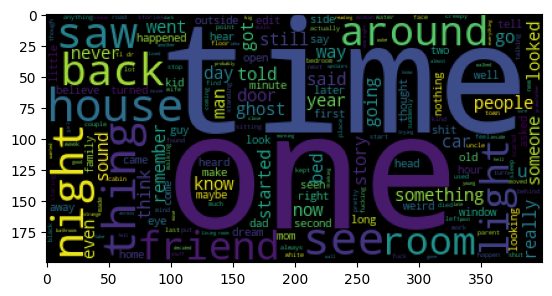

-----------
CLUSTER  11


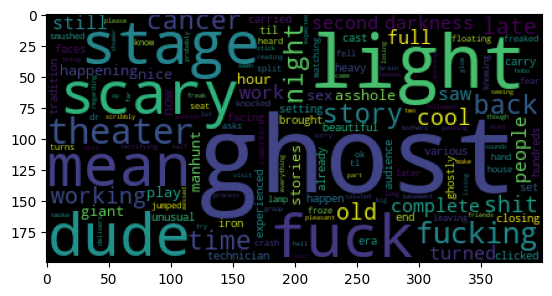

-----------
CLUSTER  8


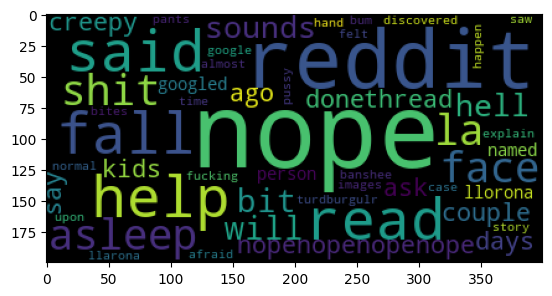

-----------
CLUSTER  2


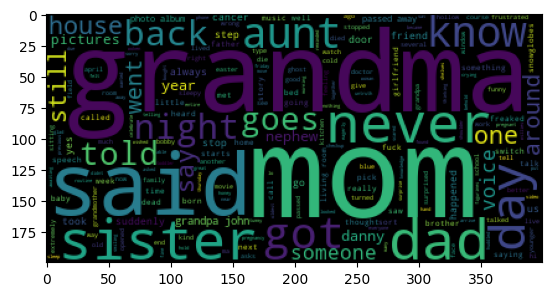

-----------
CLUSTER  10


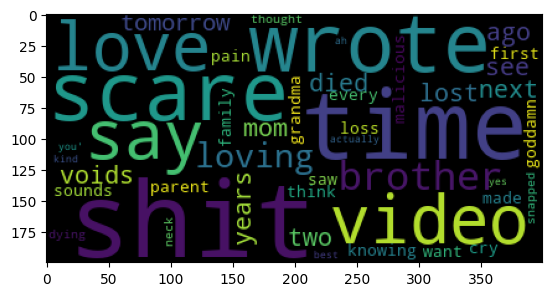

-----------


In [20]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example, Ghosts and UFOs.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [21]:
from sklearn.decomposition import TruncatedSVD
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.181695,-0.068446,0.149609,-0.000161,-0.050885,0.006633,-0.010277,-0.037946,-0.091231,-0.074087,0.042359,0.002093,my father passed away last year. one item he ...
1,0.252085,-0.035031,0.273771,0.109494,0.135843,-0.048911,0.007639,0.074855,-0.046160,0.082861,-0.075473,-0.078158,my mom told me this story the other day and it...
2,0.170978,-0.010258,-0.001349,-0.122122,0.061777,0.022441,-0.034967,-0.027853,-0.034240,-0.016618,-0.141862,0.107838,"when i was 15, my mother and i were standing i..."
3,0.278594,-0.075853,-0.115379,-0.011140,0.012354,-0.055437,-0.088498,-0.160395,0.166074,0.192878,0.045048,-0.156912,scariest moment of my life happened while my f...
4,0.370845,0.009727,-0.109126,-0.065745,0.029902,-0.011801,-0.001165,-0.070721,-0.002707,0.059517,0.023386,-0.008790,i saw a 'shadow person' once.\n\ni didn't know...


In [22]:
lsa

array([[ 0.18169544, -0.06844594,  0.14960883, ..., -0.07408743,
         0.04235852,  0.00209324],
       [ 0.2520854 , -0.03503121,  0.27377107, ...,  0.08286074,
        -0.07547286, -0.07815843],
       [ 0.17097841, -0.01025835, -0.00134927, ..., -0.01661838,
        -0.14186162,  0.10783789],
       ...,
       [ 0.17920322, -0.0129671 ,  0.06810334, ...,  0.07819067,
        -0.03598774,  0.06189522],
       [ 0.13399807, -0.02725211, -0.02789101, ...,  0.0356324 ,
         0.26019845,  0.16646388],
       [ 0.16174523, -0.0064731 ,  0.00762126, ..., -0.02902288,
        -0.03492265,  0.0511946 ]])

In [27]:
import plotly.express as px

fig = px.scatter(x=topic_encoded_df.iloc[:, 0], y=topic_encoded_df.iloc[:, 1])

fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)

fig.show()


Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [28]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_13824\3040406549.py:13: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'topic_0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.181695,-0.068446,0.149609,-0.000161,-0.050885,0.006633,-0.010277,-0.037946,-0.091231,-0.074087,0.042359,0.002093,my father passed away last year. one item he ...,topic_0
1,0.252085,-0.035031,0.273771,0.109494,0.135843,-0.048911,0.007639,0.074855,-0.046160,0.082861,-0.075473,-0.078158,my mom told me this story the other day and it...,topic_2
2,0.170978,-0.010258,-0.001349,-0.122122,0.061777,0.022441,-0.034967,-0.027853,-0.034240,-0.016618,-0.141862,0.107838,"when i was 15, my mother and i were standing i...",topic_0
3,0.278594,-0.075853,-0.115379,-0.011140,0.012354,-0.055437,-0.088498,-0.160395,0.166074,0.192878,0.045048,-0.156912,scariest moment of my life happened while my f...,topic_0
4,0.370845,0.009727,-0.109126,-0.065745,0.029902,-0.011801,-0.001165,-0.070721,-0.002707,0.059517,0.023386,-0.008790,i saw a 'shadow person' once.\n\ni didn't know...,topic_0


3. Count each main topic in the corpus 

In [29]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_0     203
topic_4      30
topic_3      29
topic_1      28
topic_9      27
topic_11     22
topic_10     21
topic_7      21
topic_2      20
topic_8      19
topic_6      18
topic_5      15
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [30]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,001a4bcf6878,00am,00pm,06,0gxcpvi,0mnk5pc,10,100,10pm,11,...,yesterday,young,younger,youth,yukon,zag,zig,zimbabwe,zinc,zone
topic_0,0.001021,0.001158,0.001158,0.007670,0.002434,0.001606,0.031815,0.010471,0.003344,0.005603,...,0.000929,0.050142,0.001525,0.001558,0.002867,0.002204,0.002204,0.001269,0.001931,0.002936
topic_1,0.000076,0.000763,0.000763,0.003596,0.000198,0.025630,0.009718,0.004355,0.001036,0.002462,...,0.000519,0.024010,0.000871,0.001003,0.001863,0.002292,0.002292,0.000365,0.000226,0.002047
topic_2,0.000417,0.001861,0.001861,0.009039,0.004545,0.002283,0.001355,0.004242,0.004221,0.003608,...,0.000666,0.013879,0.000599,0.000635,0.000863,0.002290,0.002290,0.000729,0.001983,0.002298
topic_3,0.000479,0.001094,0.001094,0.004399,0.004943,0.001802,0.006869,0.005804,0.001756,0.002317,...,0.001374,0.025570,0.000358,0.000693,0.004751,0.000934,0.000934,0.000196,0.001338,0.002645
topic_4,0.000470,0.000921,0.000921,0.002466,0.003990,0.006266,0.015326,0.005035,0.000690,0.002015,...,0.000496,0.043227,0.000185,0.000434,0.002552,0.001424,0.001424,0.001522,0.000687,0.000501


In [31]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['like', 'time', 'say', 'house', 'door']

-------------------------

TOPIC : topic_1
['ghost', 'nice', 'mean', 'cancer', 'sex']

-------------------------

TOPIC : topic_2
['say', 'mom', 'alien', 'grandma', 'fuck']

-------------------------

TOPIC : topic_3
['story', 'fuck', 'door', 'open', 'house']

-------------------------

TOPIC : topic_4
['fuck', 'dream', 'happen', 'grandma', 'dude']

-------------------------

TOPIC : topic_5
['alien', 'love', 'dead', 'shit', 'say']

-------------------------

TOPIC : topic_6
['alien', 'shit', 'fuck', 'happen', 'dude']

-------------------------

TOPIC : topic_7
['grandma', 'time', 've', 'man', 'nope']

-------------------------

TOPIC : topic_8
['alien', 'dead', 'time', 'grandma', 'dream']

-------------------------

TOPIC : topic_9
['mean', 'like', 'sound', 'reddit', 'story']

-------------------------

TOPIC : topic_10
['nope', 'grandma', 'house', 'mean', 'scary']

-------------------------

TOPIC : topic_11
['nope', 'reddit',

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [32]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.181695,-0.068446,0.149609,-0.000161,-0.050885,0.006633,-0.010277,-0.037946,-0.091231,-0.074087,0.042359,0.002093,my father passed away last year. one item he ...,topic_0
1,0.252085,-0.035031,0.273771,0.109494,0.135843,-0.048911,0.007639,0.074855,-0.046160,0.082861,-0.075473,-0.078158,my mom told me this story the other day and it...,topic_2
2,0.170978,-0.010258,-0.001349,-0.122122,0.061777,0.022441,-0.034967,-0.027853,-0.034240,-0.016618,-0.141862,0.107838,"when i was 15, my mother and i were standing i...",topic_0
3,0.278594,-0.075853,-0.115379,-0.011140,0.012354,-0.055437,-0.088498,-0.160395,0.166074,0.192878,0.045048,-0.156912,scariest moment of my life happened while my f...,topic_0
4,0.370845,0.009727,-0.109126,-0.065745,0.029902,-0.011801,-0.001165,-0.070721,-0.002707,0.059517,0.023386,-0.008790,i saw a 'shadow person' once.\n\ni didn't know...,topic_0


-------------------------

TOPIC  topic_0


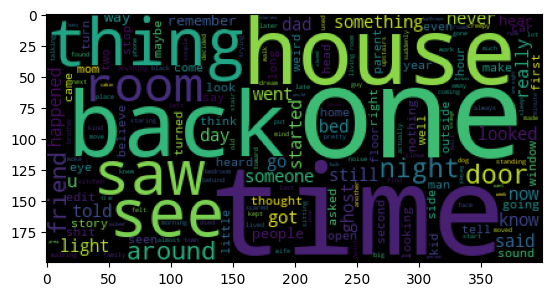


-------------------------

TOPIC  topic_1


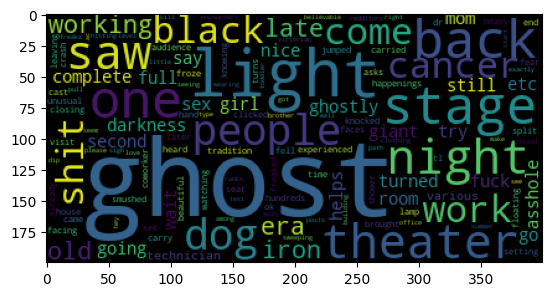


-------------------------

TOPIC  topic_2


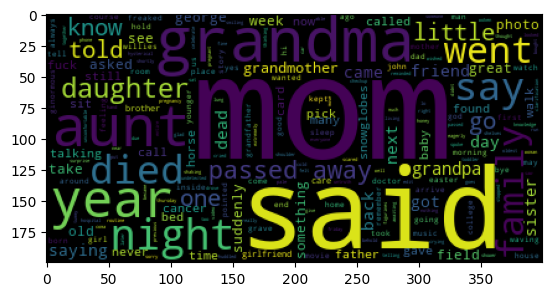


-------------------------

TOPIC  topic_3


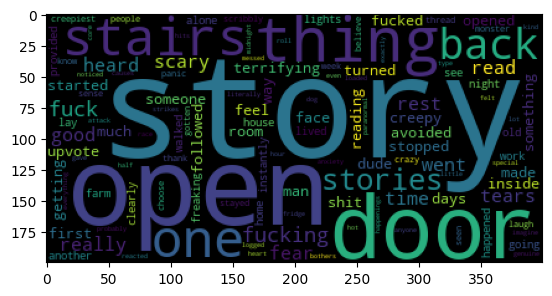


-------------------------

TOPIC  topic_4


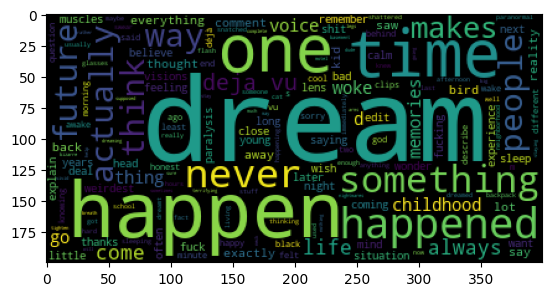


-------------------------

TOPIC  topic_5


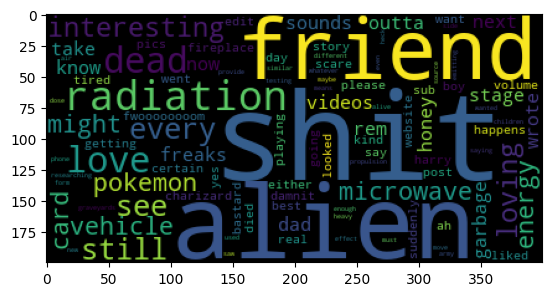


-------------------------

TOPIC  topic_6


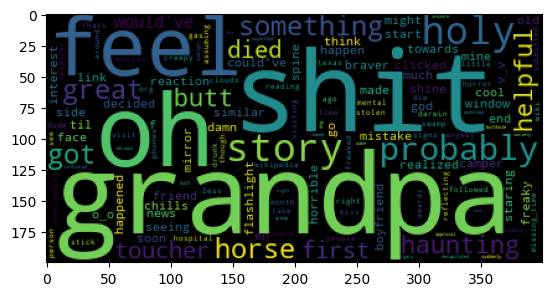


-------------------------

TOPIC  topic_7


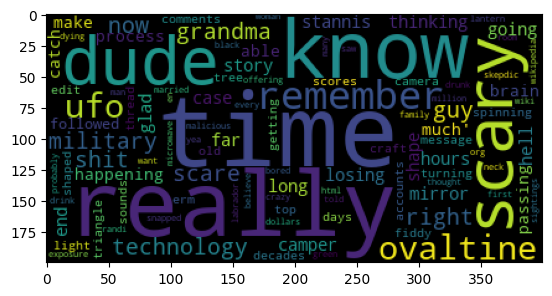


-------------------------

TOPIC  topic_8


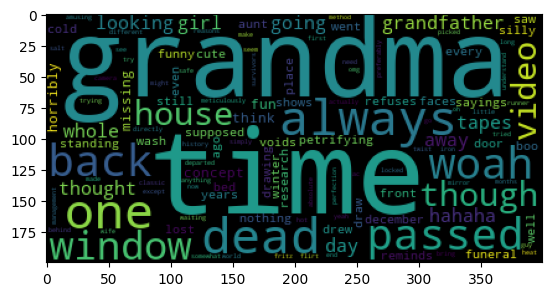


-------------------------

TOPIC  topic_9


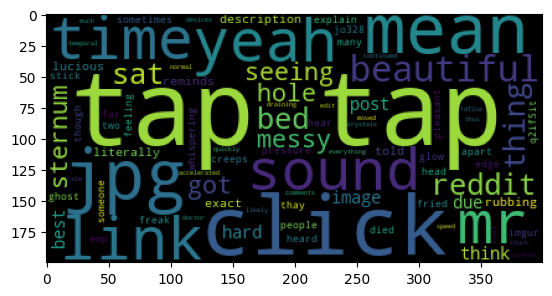


-------------------------

TOPIC  topic_10


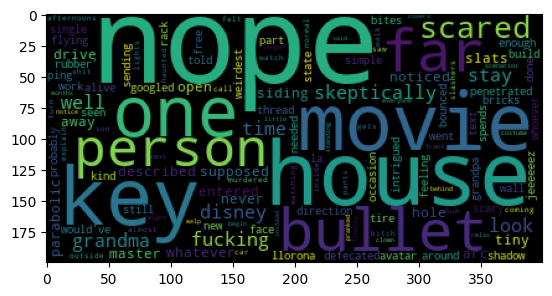


-------------------------

TOPIC  topic_11


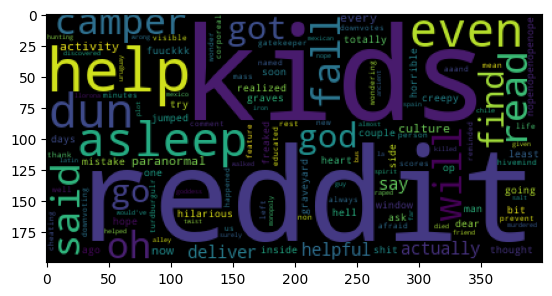

In [33]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.